# **Aprendizaje Automático para Machine Learning**

##*Perceptron*##

###Andrea Azábal Lamoso###

21 de julio de 2021

---

# Preparación del entorno

Importamos los paquetes necesarios:

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sn
import re
import matplotlib.pyplot as plt

# Generación del *dataset*

Vamos a valernos del paquete `make_blobs` para generar un *dataset* de 2000 instancias con dos atributos y una clase con dos posibles valores. A continuación, se representa gráficamente:




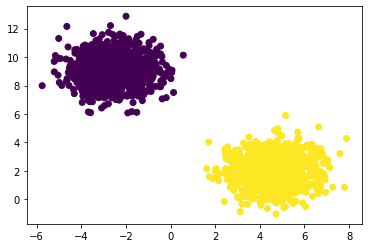

In [ ]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=2000, n_features=2, centers=2, random_state=42)
plt.scatter(x=X[:,0], y=X[:,1], c=y)
plt.show()

Una vez generado el conjunto de datos, procedemos a dividirlo en 80% *train* y 20% *test*. De esta forma, podremos evaluar el algoritmo una vez entrenado.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(1600, 2) (1600,)
(400, 2) (400,)


#Perceptrón

A lo largo de esta tarea se va a implementar un perceptrón, el cual es un algoritmo supervisado de clasificación. En su forma más simple, este contiene $N$ nodos o *inputs* (uno para cada fila del *dataset* de entrada), seguidos de una capa con un único nodo.

Los nodos están relacionados entre sí a través del vector de pesos $w$. El objetivo es obtener un *set* de pesos $w_i$ capaz de clasificar correctamente cada instancia del subconjunto de entrenamiento. Para ello, se aplica iterativamente el *set* de entrada en varias iteraciones o *epochs* hasta que el vector $w$ es capaz de separar las dos clases. En cada iteración, para cada observación del *dataset* se calcula el producto escalar:

$$ z = \sum _{i=0}^{n-1} w_i x_i = w \cdot x  $$

La clase final se determinará al aplicar la función de activación, que compara el resultado del producto escalar con un determinado umbral de forma que si este se supera, se activa la salida de la neurona. La función de activación más simple es la *step function*, sin embargo, a lo largo de esta tarea se aplicará la función sigmoide:

$$ \sigma(z) = \frac{1}{1+e^{-w \cdot z}} \ \to \ \sigma(z)'=\sigma(z)(1-\sigma(z))$$

La salida de la sigmoide se puede interpretar como la probabilidad de una de las clases frente a la otra, lo cual facilita el entrenamiento de la red comparado con la función *step*.



Con el objetivo de alcanzar los valores óptimos del vector de pesos $w$, debe definirse una **función de coste, error o pérdida (loss)** a la salida, de forma que podamos evaluar cuánto se desvía la salida actual frente a la esperada durante el entrenamiento. La minimización de dicha función de coste se lleva a cabo mediante un **descenso del gradiente**, el cual consiste en actualizar el vector de pesos en cada iteración:

<br>
$$\bbox[5px,border: 1px solid blue]{w(t+1) = w(t) - \alpha\frac{\partial Error}{\partial w}} $$
<br>

De esta manera, se reduce la función de coste hasta alcanzar un mínimo; aunque puede ocurrir que este mínimo sea local en lugar de global. La velocidad con la que alcanzamos dicho mínimo viene dada por el parámetro $\alpha$ o *learning rate*. Hay que tener cuidado a la hora de definir este parámetro, pues puede darse una de las siguientes casuísticas:

* un valor pequeño puede hacer converger en un mínimo local y parar el entrenamiento.

* un valor grande puede hacer que la red sea inestable y no converja.

En concreto, en nuestro caso, el descenso del gradiente adquiere la forma:

$$  W(t+1) = W(t) - \alpha \cdot (\sigma(z)-y)\cdot \sigma(z) (1-\sigma(z)) \cdot x $$ 

donde $y$ es la salida esperada y $\sigma(z)$ la función sigmoide previamente definida.

Finalmente, una vez se tenga el modelo entrenado y conozcamos los pesos $w_i$ definitivos, el umbral de la función de activación en la predicción se fijará de manera que la clase 1 se obtenga de la siguiente forma: $\sigma(z)\geq0.5 \ \to \ y = 1$ (cuando se supera un 50% de probabilidad).

En esta actividad, el perceptrón llevará a cabo un total de $m$ iteraciones (con un *learning rate* $\alpha$) tras las cuales se espera haber disminuido lo suficiente la función de coste, es decir, obtener un error lo suficientemente bajo que nos permita lanzar predicciones acertadas sobre el *dataset* de prueba.






##Clase

Se crea la clase `Perceptron`, para la cual se definen las siguientes funciones:

- `sigmoid`: la función sigmoide $\sigma(z)$ previamente definida.
- `sigmoid_`: derivada de la función sigmoide, $\sigma'(z)=\sigma(z)(1-\sigma(z))$.
- `fit`: fase de entrenamiento.
- `predict`: método de predicción una vez entrenado el algoritmo.
- `accuracy`: porcentaje de predicciones correctas.

In [ ]:
class Perceptron:

    def __init__(self, N, alpha=0.01):
         
        np.random.seed(1) #para obtener los mismos resultados en todas las ejecuciones
        self.W = np.random.randn(N) / np.sqrt(N) # Inicializamos la matriz de pesos
        self.N = N # Numero de datos de entrada
        self.alpha = alpha # Learning rate
        
    def sigmoid(self, x): 
        # función sigmoid
        return 1/(1 + np.exp(-x))

    def sigmoid_(self, x):
        # derivada de la función sigmoid
        return self.sigmoid(x) * (1 - self.sigmoid(x))
    
    def fit(self, X, y, epochs=10, addBias=True):
        # Bias: columna de 1s como última entrada de la matriz de pesos
        if addBias:
            print("Bias =", addBias)
            X = np.c_[X, np.ones((X.shape[0]))]
            self.W = np.random.randn(self.N+1) / np.sqrt(self.N)
        w = np.zeros([epochs, X.shape[1]])

        # Inicializamos la función de coste
        self.cost = np.zeros([epochs])

        # iteramos
        for epoch in np.arange(0, epochs):
            cumulative_cost=0
            for (x, target) in zip(X, y):
            # realizamos el producto escalar y aplicamos la función sigmoid
                p = self.sigmoid(np.dot(x, self.W))
                # actualizamos pesos si la predicción es distinta del target
                if p != target:
                    # calculamos el error y delta
                    error = (p - target)
                    delta = error * self.sigmoid_(np.dot(x, self.W))
                    # error acumulado en la iteración
                    cumulative_cost += (error**2) / 2.0
                    # actualizamos la matriz de pesos
                    self.W += -self.alpha * delta * x 
            self.cost[epoch]=cumulative_cost
            w[epoch] = self.W
        #print(self.cost)
        # Representación de la función de coste        
        plt.plot(self.cost, label=self.alpha)
        plt.xlabel('Iteración')
        plt.ylabel('Función de coste')
        plt.legend(bbox_to_anchor=(1., 0.70, 0, 0), loc='lower left',
           ncol=2,  borderaxespad=0., title="alpha")
        return w

    def predict(self, X, addBias=True):
        # aseguramos que X es matriz
        X = np.atleast_2d(X)
        # comprobamos si hay que añadir columna de "1" para bias
        if addBias:
            X = np.c_[X, np.ones((X.shape[0]))]
            # realizamos el producto escalar y aplicamos la función sigmoide
        return np.where(self.sigmoid(np.dot(X, self.W)) >= 0.5, 1, 0) #umbral al 0.5

    def accuracy(actual, predicted):
      # Calculamos la precisión (%)
      correct = 0
      for i in range(len(actual)):
	      if actual[i] == predicted[i]:
	        correct += 1
      return correct / float(len(actual)) * 100.0   

Una vez definida la clase, podemos ver cómo se comporta el algoritmo en función de los parámetros que le asignemos en la especificación.

## *Learning rate* $\alpha$

En primer lugar, vamos a fijar el valor del número de iteraciones sobre el conjunto entero de entrenamiento, es decir, fijamos ` epochs=20`. Si iteramos desde $\alpha=0.0001$ hasta $\alpha=1$ y calculamos los valores de la precisión tanto sobre el subconjunto de *test* como sobre el de prueba:

Bias = True
Bias = True
Bias = True
Bias = True
Bias = True


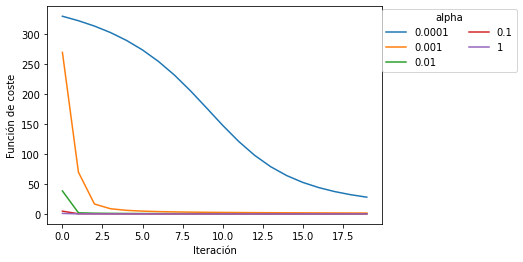

In [ ]:
lista=[0.0001,0.001,0.01,0.1,1]

md_list = []
score_train_list = []
score_test_list = []


for alpha in lista: #pruebo valores 1-9

  p = Perceptron(X_train.shape[1], alpha=alpha)
  p.fit(X_train, y_train, epochs=20, addBias=True)
  pred_train = p.predict(X_train,addBias=True)
  pred_test = p.predict(X_test,addBias=True)

  ## Generación de listas
  md_list.append(alpha)
  score_train_list.append(Perceptron.accuracy(y_train,pred_train))
  score_test_list.append(Perceptron.accuracy(y_test,pred_test))

mod1 = pd.DataFrame({"alpha":md_list, 
                   "score_train":score_train_list,
                   "score_test":score_test_list
                   })

En la representación gráfica se observa el comportamiento de la función de coste o error en función del número de iteraciones (desde 1 a 19) para cada uno de los valores de $\alpha$ planteados. Así, vemos que, a medida que aumenta el *learning rate*, la bajada se hace cada vez más pronunciada. Esto tiene sentido, pues el *learning rate* es precisamente el parámetro que determina la velocidad a la que nos acercamos al mínimo de la función de coste. 

Además, el error para $\alpha=0.0001$ es significativamente superior al resto, lo cual nos lleva a pensar que serían necesarias más iteraciones para terminar de alcanzar el mínimo de la función de coste. Como ya hemos argumentado, valores bajos de $\alpha$ pueden causar que no lleguemos "a tiempo" al mínimo y obtengamos un modelo con *underfitting* que no se ajuste bien a los datos. Por el contrario, un *learning rate* demasiado alto puede hacer que el perceptrón no converja, pues no es capaz de encontrar el mínimo de la función de coste.

In [ ]:
mod1.set_index("alpha", inplace=True)

En este caso, los valores de las precisiones obtenidos son los siguientes:

In [ ]:
mod1

,score_train,score_test
alpha,,
0.0001,99.625,99.5
0.0010,100.000,100.0
0.0100,100.000,100.0
0.1000,100.000,100.0
1.0000,100.000,100.0


Si representamos gráficamente la precisión global de cada modelo en función de $\alpha$:

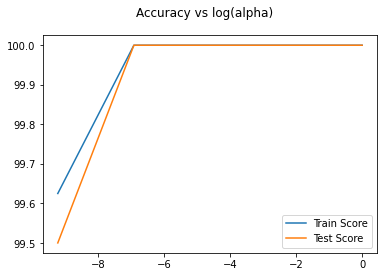

In [ ]:
fig, ax = plt.subplots()

plt.suptitle("Accuracy vs log(alpha)")
ax.plot(np.log(mod1["alpha"]), mod1["score_train"], label="Train Score")
ax.plot(np.log(mod1["alpha"]), mod1["score_test"], label="Test Score")
plt.legend()
plt.show()

En la gráfica se tiene $log(\alpha)$ para poder apreciar bien los resultados. Independientemente de la escala, se puede ver que para el valor más bajo (el cual corresponde a $\alpha=0.0001$), tenemos una *accuracy* levemente inferior a la del resto de valores, para los cuales se alcanza un 100% tanto en el subconjunto de *train* como en el de *test*.

Así, estamos observando un ligero *underfitting* para valores excesivamente bajos del *learning rate*, mientras que a partir de $\alpha\geq0.001$ tenemos un algoritmo muy preciso que converge al mínimo de la función de coste.



##Modelo final

Procedemos, por tanto, a generar el modelo final con `epochs=20` y `alpha=0.001`:

Bias = True


array([[-0.00197378, -0.61838162,  0.69377108],
       [ 0.30398368, -0.46521508,  0.76113094],
       [ 0.40615692, -0.40816944,  0.78488464],
       [ 0.46100559, -0.37960928,  0.7977    ],
       [ 0.49844701, -0.36274406,  0.80623928],
       [ 0.52710223, -0.35212849,  0.81254049],
       [ 0.55049761, -0.34529177,  0.81748298],
       [ 0.57038904, -0.3408924 ,  0.82152485],
       [ 0.58776942, -0.33812559,  0.82493367],
       [ 0.6032533 , -0.33647917,  0.82787798],
       [ 0.61724773, -0.33561466,  0.8304698 ],
       [ 0.63003693, -0.33530237,  0.8327867 ],
       [ 0.64182779, -0.3353833 ,  0.83488414],
       [ 0.65277609, -0.33574557,  0.83680286],
       [ 0.66300238, -0.3363094 ,  0.83857352],
       [ 0.67260211, -0.33701724,  0.84021962],
       [ 0.68165229, -0.3378272 ,  0.84175955],
       [ 0.69021608, -0.33870846,  0.84320789],
       [ 0.69834598, -0.33963827,  0.84457641],
       [ 0.7060862 , -0.3405997 ,  0.8458747 ]])

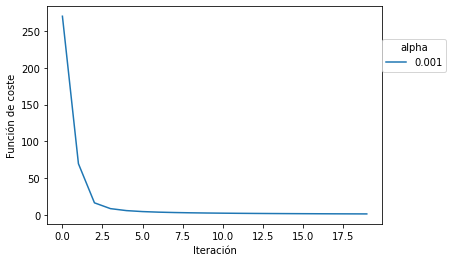

In [ ]:
p = Perceptron(X_train.shape[1], alpha=0.001)
p.fit(X_train, y_train, epochs=20, addBias=True)

En el *output* se han devuelto los valores finales de la matriz de pesos $w$ y se ha representado el error en función del parámetro `epochs`, viéndose claramente cómo va convergiendo hacia un mínimo.

Aplicando el perceptrón ya entrenado sobre el *dataset* de prueba obtenemos:

In [ ]:
pred_list = []
for (x, target) in zip(X_test, y_test):
    # hacemos un predicción y comprobamos
    pred = p.predict(x,addBias=True)
    print("dato={}, target={}, pred={}".format(
        x, target, pred))
    pred_list.append(pred)

dato=[-2.99804704  7.89466869], target=0, pred=[0]
dato=[-2.64765361  7.78998789], target=0, pred=[0]
dato=[3.93298627 2.82872534], target=1, pred=[1]
dato=[-2.52861723  8.71110635], target=0, pred=[0]
dato=[-2.49076369  9.36186783], target=0, pred=[0]
dato=[3.39416146 2.02810379], target=1, pred=[1]
dato=[4.9923838  1.40281832], target=1, pred=[1]
dato=[-3.73132543  9.72728456], target=0, pred=[0]
dato=[-2.22820576  8.39158661], target=0, pred=[0]
dato=[5.33870726 2.39414263], target=1, pred=[1]
dato=[-2.36831138  7.24584676], target=0, pred=[0]
dato=[2.73052275 3.29147201], target=1, pred=[1]
dato=[-1.4851351   9.60681308], target=0, pred=[0]
dato=[4.22805547 2.10509765], target=1, pred=[1]
dato=[-3.61490229  8.7993651 ], target=0, pred=[0]
dato=[-2.20036461 10.71650107], target=0, pred=[0]
dato=[-2.53671253 10.78653772], target=0, pred=[0]
dato=[-2.95926309  9.63713606], target=0, pred=[0]
dato=[4.80036846 4.18570072], target=1, pred=[1]
dato=[5.19302799 1.42496939], target=1, pred=

Asimismo, podemos recuperar la *accuracy* global del modelo:

In [ ]:
pred = p.predict(X_test,addBias=True)
# Calculate accuracy percentage
Perceptron.accuracy(y_test,pred)

100.0

Como ya habíamos obtenido, el modelo tiene una precisión del 100% sobre el subconjunto de prueba. Así, la matriz de confusión se vuelve trivial pues solo tiene observaciones en la diagonal:

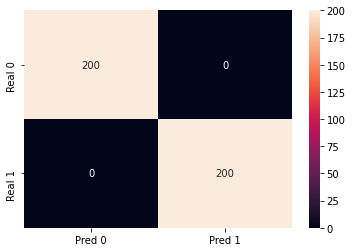

In [ ]:
from sklearn.metrics import confusion_matrix
matriz=confusion_matrix(y_test, pred)
sn.heatmap(pd.DataFrame(matriz), 
           annot=True,fmt='g',xticklabels=('Pred 0','Pred 1'),yticklabels=('Real 0','Real 1'))

Es decir, tanto el *precision* como el *recall* son del 100%.

#Conclusiones

En esta tarea se ha implementado un algoritmo de clasificación con el objetivo de clasificar un *dataset* de 2.000 puntos en un espacio bidimensional (dos características o *features*), cada uno de ellos con una etiqueta con dos valores posibles.

En concreto, se ha implementado un perceptrón simple, el cual se ha entrenado con un 80% del *dataset* inicial. Durante el entrenamiento, se han aplicado distintas parametrizaciones con el fin de encontrar la especificación más óptima al evaluarse sobre el *dataset* de prueba restante. 

Así, se ha seleccionado un *learning rate* de 0.001 y se ha entrenado durante 20 iteraciones o *epochs*. El resultado es una precisión del 100% sobre el subconjunto de *testing*, es decir, el algoritmo ha acertado en todas las predicciones realizadas. 

Este éxito en la clasificación probablemente se deba a la simplicidad del *dataset* seleccionado, pues las dos clases están muy separadas entre sí, lo cual facilita el aprendizaje del perceptrón y hace que con pocas iteraciones y un *learning rate* relativamente bajo sea capaz de dividir el plano bidimensional correctamente.


    